In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";   

# Text Classification with Hugging Face Transformers in *ktrain*

As of v0.8.x, *ktrain* now includes an easy-to-use, thin wrapper to the Hugging Face transformers library for text classification.

## Load Data Into Arrays

In [2]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

print('size of training set: %s' % (len(train_b['data'])))
print('size of validation set: %s' % (len(test_b['data'])))
print('classes: %s' % (train_b.target_names))

x_train = train_b.data
y_train = train_b.target
x_test = test_b.data
y_test = test_b.target

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


## STEP 1: Preprocess Data and Build a Transformer Model

For `MODEL_NAME`, *ktrain* supports both the "official" built-in models [available here](https://huggingface.co/transformers/pretrained_models.html) and the [community-upoaded models available here](https://huggingface.co/models).

In [3]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=train_b.target_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

using Keras version: 2.2.4-tf
preprocessing train...
language: en


preprocessing test...
language: en


Note that `x_train` and `x_test` are the raw texts that look like this:
```python
x_train = ['I hate this movie.', 'I like this movie.']
```
The labels are arrays in one of the following forms:
```python
# string labels
y_train = ['negative', 'positive']
# integer labels
y_train = [0, 1]
# multi or one-hot encoded labels
y_train = [[1,0], [0,1]]
```
In the latter two cases, you must supply a `class_names` argument to the `Transformer` constructor, which tells *ktrain* how indices map to class names.  In this case, `class_names=['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']` because 0=alt.atheism, 1=comp.graphics, etc.

## STEP 2 [Optional]: Estimate a Good Learning Rate

Learning rates between `2e-5` and `5e-5` tend to work well with transformer models based on papers from Google. However, we will run our learning-rate-finder for two epochs to estimate the LR on this particular dataset.

As shown below, our results are consistent Google's findings.

simulating training for different learning rates... this may take a few moments...
Train for 376 steps
Epoch 1/2
376/376 [==============================] - 73s 194ms/step - loss: 1.0788 - accuracy: 0.5191
Epoch 2/2
115/376 [========>.....................] - ETA: 43s - loss: 1.9950 - accuracy: 0.2482

done.


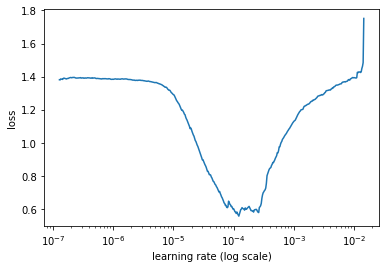

In [5]:
learner.lr_find(show_plot=True, max_epochs=2)

## STEP 3: Train Model

Train using a [1cycle learning rate schedule](https://arxiv.org/pdf/1803.09820.pdf).

In [4]:
learner.fit_onecycle(8e-5, 4)



begin training using onecycle policy with max lr of 8e-05...
Train for 377 steps, validate for 251 steps
Epoch 1/4
377/377 [==============================] - 89s 236ms/step - loss: 0.5214 - accuracy: 0.8285 - val_loss: 0.2847 - val_accuracy: 0.9081
Epoch 2/4
377/377 [==============================] - 80s 213ms/step - loss: 0.1524 - accuracy: 0.9513 - val_loss: 0.5775 - val_accuracy: 0.8309
Epoch 3/4
377/377 [==============================] - 81s 215ms/step - loss: 0.1066 - accuracy: 0.9739 - val_loss: 0.2469 - val_accuracy: 0.9387
Epoch 4/4
377/377 [==============================] - 81s 215ms/step - loss: 0.0318 - accuracy: 0.9907 - val_loss: 0.1645 - val_accuracy: 0.9561


## STEP 4: Evaluate/Inspect Model

In [5]:
learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

           alt.atheism       0.92      0.93      0.93       319
         comp.graphics       0.97      0.97      0.97       389
               sci.med       0.97      0.95      0.96       396
soc.religion.christian       0.96      0.96      0.96       398

              accuracy                           0.96      1502
             macro avg       0.95      0.96      0.95      1502
          weighted avg       0.96      0.96      0.96      1502



array([[298,   2,   8,  11],
       [  7, 378,   3,   1],
       [  5,   8, 378,   5],
       [ 15,   0,   1, 382]])

In [6]:
# the one we got most wrong
learner.view_top_losses(n=1, preproc=t)

----------
id:521 | loss:7.12 | true:sci.med | pred:comp.graphics)



In [7]:
# understandable mistake - this sci.med post talks a lot about computer graphics
print(x_test[521])

From: jim.zisfein@factory.com (Jim Zisfein) 
Subject: Data of skull
Distribution: world
Organization: Invention Factory's BBS - New York City, NY - 212-274-8298v.32bis
Reply-To: jim.zisfein@factory.com (Jim Zisfein) 
Lines: 11

GT> From: gary@concave.cs.wits.ac.za (Gary Taylor)
GT> Hi, We are trying to develop a image reconstruction simulation for the skull

You could do high resolution CT (computed tomographic) scanning of
the skull.  Many CT scanners have an algorithm to do 3-D
reconstructions in any plane you want.  If you did reconstructions
every 2 degrees or so in all planes, you could use the resultant
images to create user-controlled animation.
---
 . SLMR 2.1 . E-mail: jim.zisfein@factory.com (Jim Zisfein)
                                                                                                                        



## STEP 5: Make Predictions on New Data in Deployment

In [8]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [9]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [10]:
predictor.explain('Jesus Christ is the central figure of Christianity.')

In [11]:
predictor.save('/tmp/my_20newsgroup_predictor')

In [12]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_20newsgroup_predictor')

In [13]:
reloaded_predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [14]:
reloaded_predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

array([8.9553175e-03, 3.1522836e-04, 3.8172584e-04, 9.9034774e-01],
      dtype=float32)

In [15]:
reloaded_predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']